03.5_Model_Evaluation.ipynb

# Model Evaluation

Noteboook to perform model evaluation for the following trained models
- VGG19
- ResNet18

Note the training was performed on the [DeepFire Dataset](https://doi.org/10.1155/2022/5358359). The details are available on the following notebooks.
- `03_VGG19_TransferLearning.ipynb`
- `03_Resnet18_TransferLearning.ipynb`

## Steps
1. We will use the test set from `02_dataset` and import custom modules to calculate the following evaluation metrics:
- Confusion Matrix
- Classification Report
- ROC plot and AUC score

2. We'll take a look at the misclassified predictions from each model.

4. We will see how each model performs with unseen images from the [Wildfire Dataset](https://doi.org/10.3390/f14091697).

## Import Usual Libraries

In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Import Custom Modules

In [2]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [3]:
sys.path.append('..')

In [4]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're just keeping the image size consistent with the training we performed previously. The batch size is not too important for inference purposes.

In [5]:
BATCH_SIZE = 64
N_CLASSES = 2
# to be used for height and width of final image
IMAGE_SIZE = 128

In [6]:
# Set manual seed for repeatability
RANDOM_SEED = 42
gen = torch.manual_seed(RANDOM_SEED)

# Prepare Test Data

## Define Custom Class and Paths

In [7]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [8]:
path_to_dataset = '../data_preprocessing/02_forest_fire_dataset/'
annotations_file_test = 'labels_02_test_dataset_prep.csv'
annotations_file_train = 'labels_02_train_dataset_prep.csv'

## Load Test Dataset

Recall previously we calculated the Statistics of Train Dataset
as follows
- Mean: [0.4249, 0.3509, 0.2731]
- STD: [0.2766, 0.2402, 0.2612]

In [9]:
# similar to before, but added an additional normalization
# according to the statistics we calculated
mean_train = [0.4249, 0.3509, 0.2731]
std_train = [0.2766, 0.2402, 0.2612]

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean_train,std_train)
                                 ])

In [10]:
# Define image classes
img_classes = ('non-fire','fire')

In [11]:
test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf)

In [12]:
print('Test Dataset\t',len(test_dataset))

Test Dataset	 380


In [13]:
# create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, num_workers = 4)

## Instantiate Models and Load State Dictionary

In [14]:
from src.models.model_transfer_learning import vgg19_transfer_learning
from src.models.model_transfer_learning import resnet18_transfer_learning

In [15]:
model_dictionary = {
    'VGG19':vgg19_transfer_learning(N_CLASSES),
    'ResNet18':resnet18_transfer_learning(N_CLASSES)
}

In [16]:
model_dictionary['VGG19'].load_state_dict(torch.load('vgg19_v3_trained.pt'))
model_dictionary['VGG19'].eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
model_dictionary['ResNet18'].load_state_dict(torch.load('resnet18_v2_trained.pt'))
model_dictionary['ResNet18'].eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Make Predictions with Each Model

Recall that for the confusion matrix, the entries are as follows

|true labels|||
|:---:|:---:|:---:|
|no-fire|TN|FP|
|fire|FN|TP|
|    |no-fire|fire|
| |     **predicted labels**|

In [18]:
from src.models.model_inference import make_hard_predictions

In [19]:
from src.visualization.plot_model_eval import calculate_conf_matrix
from src.visualization.plot_model_eval import plot_roc_curve

In [20]:
help(calculate_conf_matrix)

Help on function calculate_conf_matrix in module src.visualization.plot_model_eval:

calculate_conf_matrix(label_list, pred_list, model_name, img_classes, savefig=False)
    Function to calculate the Confusion Matrix and the classification
    report.

    Parameters
    ----------
    label_list : list or array
        True labels
    pred_list : list or array
        Predictions from the model
    model_name : string
        Name of the model being evaluated
    img_classes : list
        Classes of the classification problem. Preferably a list of strings.
    savefig : bool, optional
        To save figure (confusion matrix) or not

    Returns
    -------
    string
        Classification Report



In [21]:
help(plot_roc_curve)

Help on function plot_roc_curve in module src.visualization.plot_model_eval:

plot_roc_curve(label_list, pred_list, model_name, savefig=False)
    Function to plot the ROC curve. It also calculates the AUC score.

    Parameters
    ----------
    label_list : list or array
        True labels
    pred_list : list or array
        Predictions from the model
    model_name : string
        Name of the model being evaluated
    savefig : bool, optional
        To save figure (ROC curve with AUC score) or not

    Returns
    -------
    number
        The calculated AUC score.



### VGG19

In [22]:
label_list, pred_list = make_hard_predictions(model_dictionary['VGG19'],test_dataloader)

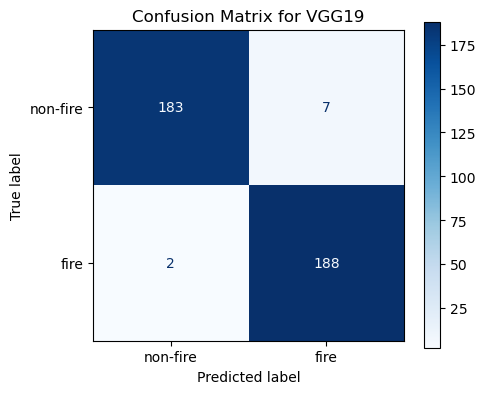

              precision    recall  f1-score   support

           0     0.9892    0.9632    0.9760       190
           1     0.9641    0.9895    0.9766       190

    accuracy                         0.9763       380
   macro avg     0.9766    0.9763    0.9763       380
weighted avg     0.9766    0.9763    0.9763       380



In [23]:
report = calculate_conf_matrix(label_list,pred_list, 'VGG19',img_classes)

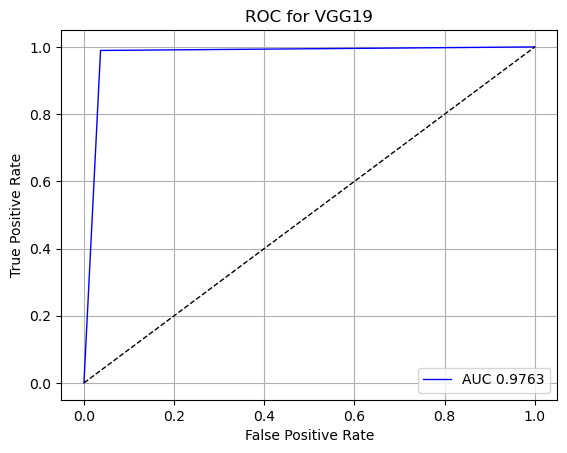

In [24]:
score = plot_roc_curve(label_list,pred_list,'VGG19')

So far everything is in line with what we calculated previously.

### ResNet18

In [25]:
label_list_resnet, pred_list_resnet = make_hard_predictions(model_dictionary['ResNet18'],test_dataloader)

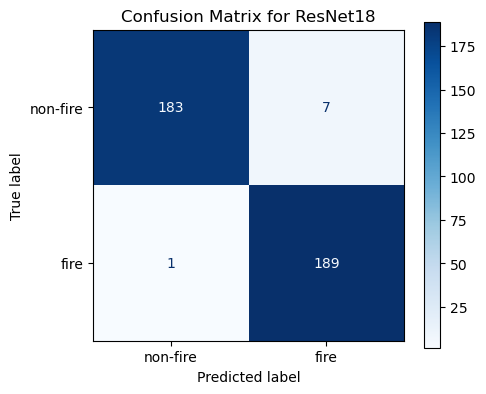

              precision    recall  f1-score   support

           0     0.9946    0.9632    0.9786       190
           1     0.9643    0.9947    0.9793       190

    accuracy                         0.9789       380
   macro avg     0.9794    0.9789    0.9789       380
weighted avg     0.9794    0.9789    0.9789       380



In [26]:
report = calculate_conf_matrix(label_list_resnet,pred_list_resnet, 'ResNet18',img_classes,savefig = True)

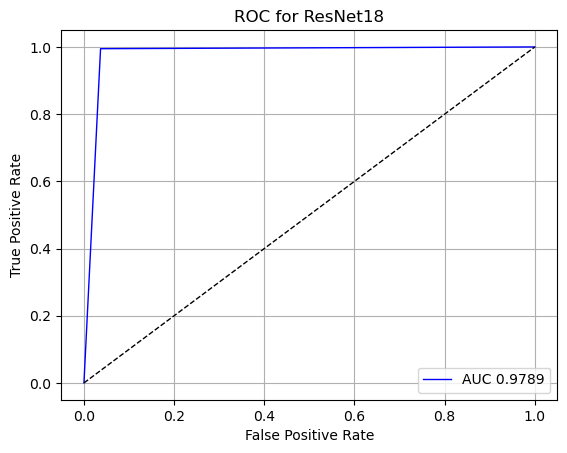

In [27]:
score = plot_roc_curve(label_list_resnet,pred_list_resnet,'ResNet18')

Similarly, everything looks in line with what we had calculated before.

# Taking a Closer Look at False Positives and False Negatives

From the confusion matrices above, we see that both models have:
- 1 or 2 False Negatives (VGG and ResNet, respectively)
- 7 False Positives

Let's use the annotations file to identify the images that were misclassified and see if they are the same for both models.

In [28]:
import os
import pandas as pd

path_and_annot_file_test = os.path.join(path_to_dataset,annotations_file_test)
df = pd.read_csv(path_and_annot_file_test, header = None)
df.columns = ['item','label']
df

item  label
0        ./testing/fire/fire_0648.jpg      1
1        ./testing/fire/fire_0890.jpg      1
2        ./testing/fire/fire_0927.jpg      1
3        ./testing/fire/fire_0728.jpg      1
4        ./testing/fire/fire_0072.jpg      1
..                                ...    ...
375  ./testing/nofire/nofire_0206.jpg      0
376  ./testing/nofire/nofire_0400.jpg      0
377  ./testing/nofire/nofire_0372.jpg      0
378  ./testing/nofire/nofire_0831.jpg      0
379  ./testing/nofire/nofire_0158.jpg      0

[380 rows x 2 columns]

In [29]:
df.shape

(380, 2)

Add a new column for predicted labels, one for each model.

In [30]:
# putting -1 just to make it very explicit those values are incorrect for now.
df['pred'] = -1

# dataframe for all predictions from VGG
pred_vgg_df = df.copy()
pred_vgg_df.head()

item  label  pred
0  ./testing/fire/fire_0648.jpg      1    -1
1  ./testing/fire/fire_0890.jpg      1    -1
2  ./testing/fire/fire_0927.jpg      1    -1
3  ./testing/fire/fire_0728.jpg      1    -1
4  ./testing/fire/fire_0072.jpg      1    -1

In [31]:
# dataframe for all predictions from ResNet18
pred_resnet_df = df.copy()
pred_resnet_df.head()

item  label  pred
0  ./testing/fire/fire_0648.jpg      1    -1
1  ./testing/fire/fire_0890.jpg      1    -1
2  ./testing/fire/fire_0927.jpg      1    -1
3  ./testing/fire/fire_0728.jpg      1    -1
4  ./testing/fire/fire_0072.jpg      1    -1

In [32]:
# temporary column just to double check the `label_list` matches the
# `label` column in the dataframe
df['temp_label'] = label_list
df.query('label != temp_label')

Empty DataFrame
Columns: [item, label, pred, temp_label]
Index: []

We see the query returns an empty dataframe, so it's true that `label_list` is the same as `label` for VGG19 and ResNet18.

In [33]:
# Assign predictions from VGG
pred_vgg_df['pred'] = pred_list
pred_vgg_df.head()

item  label  pred
0  ./testing/fire/fire_0648.jpg      1     1
1  ./testing/fire/fire_0890.jpg      1     1
2  ./testing/fire/fire_0927.jpg      1     1
3  ./testing/fire/fire_0728.jpg      1     1
4  ./testing/fire/fire_0072.jpg      1     1

Next, it's ResNet with its predictions

In [34]:
pred_resnet_df['pred'] = pred_list_resnet
pred_resnet_df.head()

item  label  pred
0  ./testing/fire/fire_0648.jpg      1     1
1  ./testing/fire/fire_0890.jpg      1     1
2  ./testing/fire/fire_0927.jpg      1     1
3  ./testing/fire/fire_0728.jpg      1     1
4  ./testing/fire/fire_0072.jpg      1     1

In [35]:
misc_vgg = pred_vgg_df.query('label != pred')
misc_resnet = pred_resnet_df.query('label != pred')

In [36]:
misc_vgg.index

Index([54, 145, 241, 278, 297, 365, 370, 374, 376], dtype='int64')

In [37]:
misc_resnet.index

Index([82, 199, 225, 241, 278, 350, 370, 376], dtype='int64')

We can see that there are only a few indices in common: 241, 278, 370, 376 

Next, we'll plot the images corresponding to each index.

In [38]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

def plot_fp_fn(misc_df,path_to_dataset,model_name,savefig = False):

    # to choose the kind of misclassification
    # pred = 0 --> FN
    # pred = 1 --> FP
    miss = ['FN','FP']
    
    for k,ind_df in enumerate(misc_df.index):    
        
        true = misc_df.loc[ind_df,'label']
        pred = misc_df.loc[ind_df,'pred']
        
        title_str = f'true: {true}\npredicted: {pred}'
    
        full_img_path = os.path.join(path_to_dataset,misc_df.loc[ind_df,'item'])
        extension = full_img_path[-4:]
    
        img = read_image(full_img_path)

        plt.figure()
        plt.title(title_str)
        plt.imshow(img.permute(1,2,0))            

        plt.tick_params(left = False, right = False, labelleft = False ,
                        labelbottom = False, bottom = False) 
        
        if savefig:
            
            figure_name = f'{model_name}_{miss[pred]}_ind{ind_df}_{extension}'
            # print(figure_name)
            plt.savefig(figure_name,bbox_inches = 'tight')
    
        plt.show()

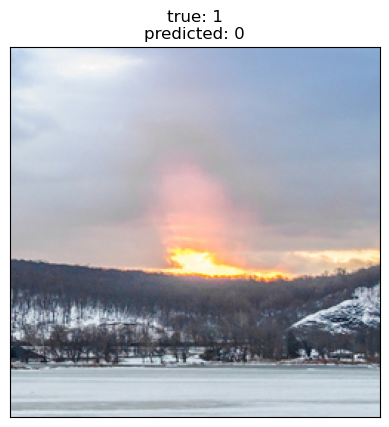

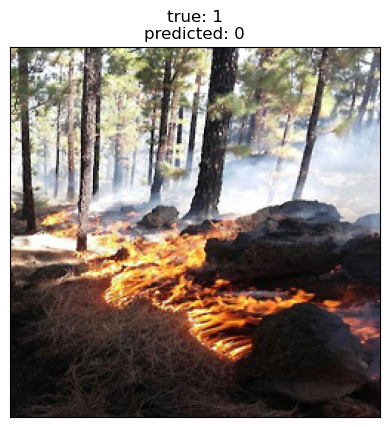

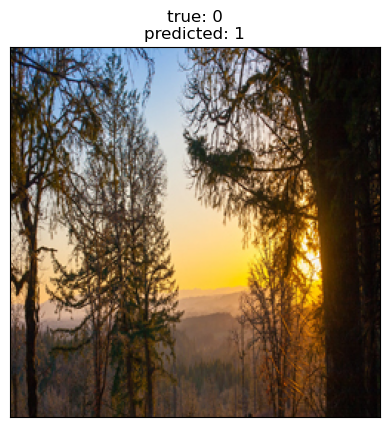

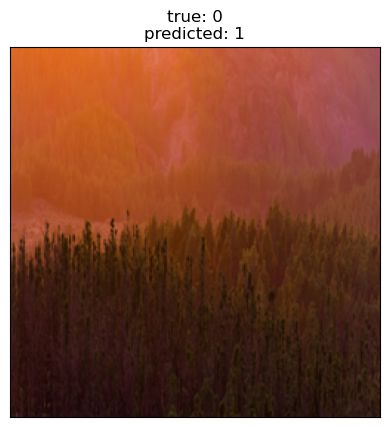

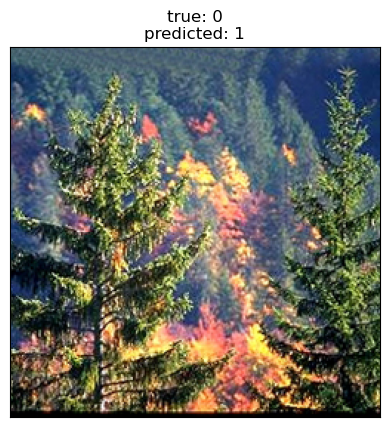

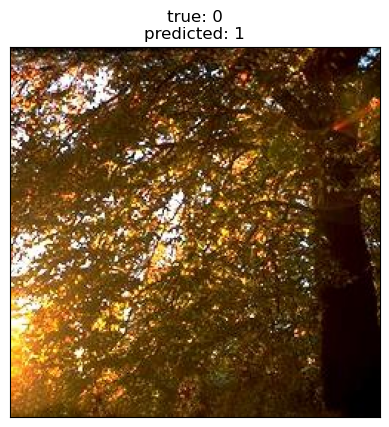

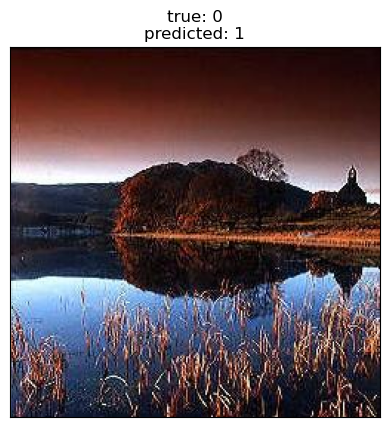

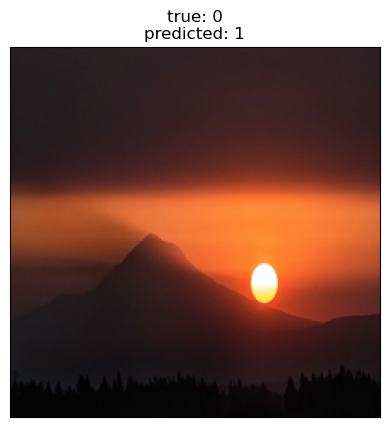

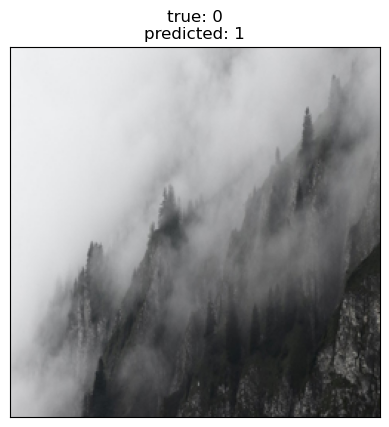

In [39]:
plot_fp_fn(misc_vgg,path_to_dataset,'VGG19',savefig = True)

It seems that VGG mis-classified some images with sunsets as images of fires. 

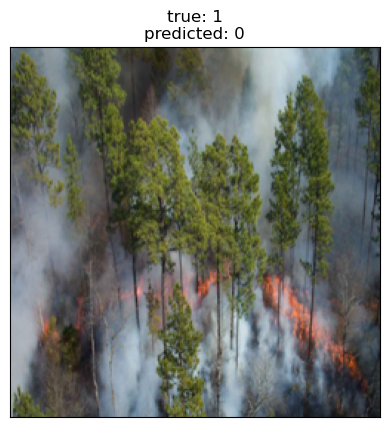

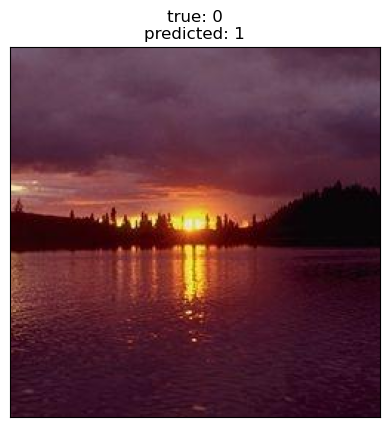

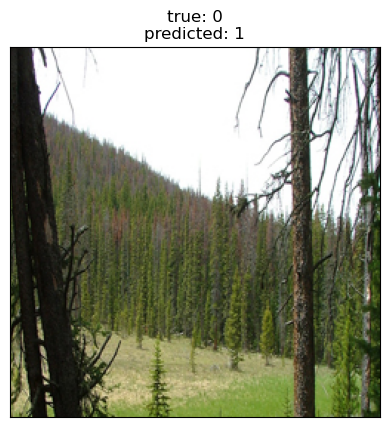

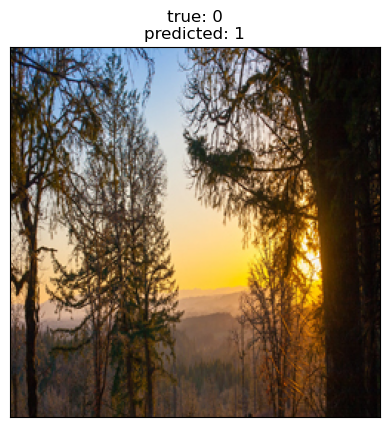

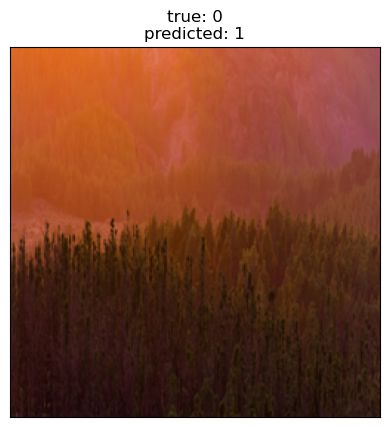

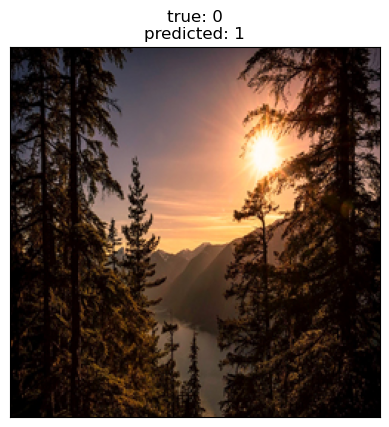

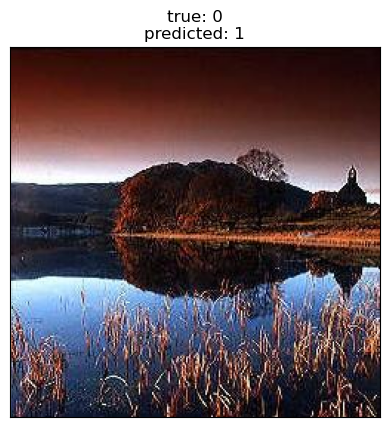

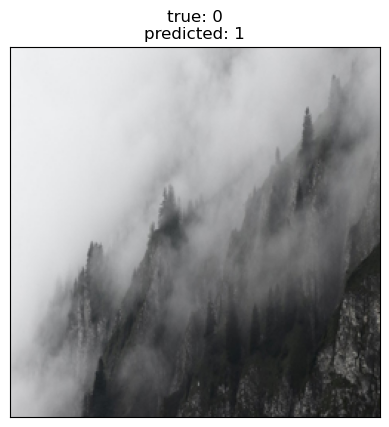

In [40]:
plot_fp_fn(misc_resnet,path_to_dataset,'ResNet18',savefig = True)

Similarly, resnet mixed up sunsets and clouds with fires.

Based on the predictions seen above, I don't expect both models to be very good with images that show smoke, sunsets, and clouds. Let's try to test that on the next section.

# Make Brand New Dataset

We'll now explore how models predict on unseen data from the [Wildfire Dataset](https://doi.org/10.3390/f14091697). 

Note the folder containing the images is `03_the_wildfire_dataset_250x250`. 

For now, we'll only resize the images from 250x250 to 128x128.

In [41]:
path_03_dataset = '../data_preprocessing/03_the_wildfire_dataset_250x250/'

annot_file_test = 'labels_03_test_dataset.csv'
annot_file_val = 'labels_03_val_dataset.csv'
annot_file_train = 'labels_03_train_dataset.csv'

In [42]:
# For now, since we don't have statistics on the new dataset, so we'll only resize.

IMAGE_SIZE = 128

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

In [43]:
test_03_dataset = CustomFireImagesDataset(annot_file_test, path_03_dataset,
                                       transform = curr_transf)

In [44]:
print('Test Dataset\t',len(test_03_dataset))

Test Dataset	 410


In [45]:
# create test dataloader
test_03_dataloader = DataLoader(test_03_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, num_workers = 2)

Make Predictions

In [46]:
label_03_vgg, pred_03_vgg = make_hard_predictions(model_dictionary['VGG19'],test_03_dataloader)
label_03_resnet, pred_03_resnet = make_hard_predictions(model_dictionary['ResNet18'],test_03_dataloader)

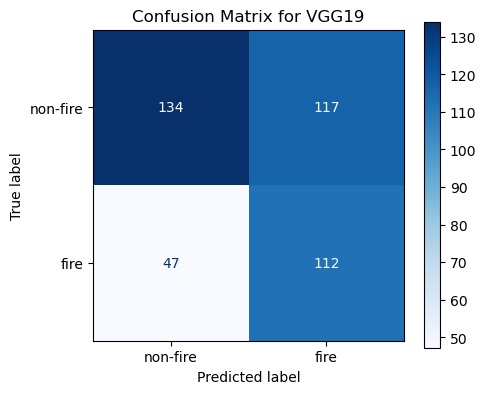

              precision    recall  f1-score   support

           0     0.7403    0.5339    0.6204       251
           1     0.4891    0.7044    0.5773       159

    accuracy                         0.6000       410
   macro avg     0.6147    0.6191    0.5988       410
weighted avg     0.6429    0.6000    0.6037       410



In [47]:
report = calculate_conf_matrix(label_03_vgg,pred_03_vgg, 'VGG19',img_classes,savefig=True)

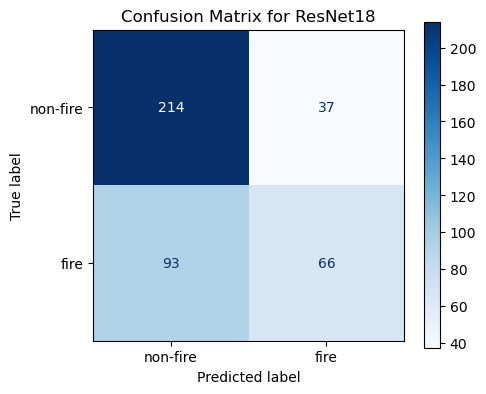

              precision    recall  f1-score   support

           0     0.6971    0.8526    0.7670       251
           1     0.6408    0.4151    0.5038       159

    accuracy                         0.6829       410
   macro avg     0.6689    0.6338    0.6354       410
weighted avg     0.6752    0.6829    0.6650       410



In [48]:
report = calculate_conf_matrix(label_03_resnet,pred_03_resnet, 'ResNet18',img_classes,savefig = True)

We see that in this new dataset, the F1 scores for both models are much lower. Hence at this point they are unable to classify images from the [Wildfire Dataset](https://doi.org/10.3390/f14091697).

We'll re-train the models on the wildfire dataset and come back to the original test dataset.

# Conclusion

We've seen that both VGG19 and ResNet18 have very good performances in the DeepFire dataset. ResNet seems to have a slight edge over VGG as it achieves higher scores overall, using less trainable parameters and less time to train.

The table below compares the performance metrics between those reported in the [DeepFire Dataset article](https://doi.org/10.1155/2022/5358359), and the models I trained.

|parameter| VGG19_DeepFire_paper | VGG19   | ResNet18  |
|----------------------|---------|-----------|----------|
| batch size           | 64      | 64        | 64       |
| learning rate        | 0.01    | 0.001     | 0.001    |
| epochs               | 50      | 10        | 20       |
| image size (pixels)  | 128x128 | 128x128   | 128x128  |
| total parameters     | N/A     | 139,578,434 | 11,177,538 |
| trainable parameters | N/A     | 8194      | 1026     |
| model size (MB)      | N/A     | 560       | 45       |
| training time        | N/A     | 15 min    | 12 min   |
| optimizer            | SGD     | Adam      | Adam     |
| accuracy             | 0.95    | 0.9763    | 0.9789   |
| precision            | 0.9572  | 0.9641    | 0.9643   |
| recall               | 0.9421  | 0.9895    | 0.9947   |
| F1 score             | 0.9496  | 0.9766    | 0.9793   |
| AUC score            | 0.9889  | 0.9763    | 0.9789   |
| FP                   | 8       | 7         | 7        |
| FN                   | 11      | 2         | 1        |
| TP                   | 179     | 188       | 189      |
| TN                   | 182     | 183       | 183      |


Lastly, we saw that trying to make predictions from the [Wildfire Dataset](https://doi.org/10.3390/f14091697) resulted in very low scores for both models. Therefore we'll have to retrain them on a new dataset.